# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 4:  Logistic Regression and PCA

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()

# if you want to do a 2-sample t-test:
from scipy.stats import ttest_ind

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The dataset is provided in the file `data/genomic_data.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [15 pts]: Data Exploration </b></div>

The first step is to split the observations into an approximate 75-25 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values**. Normalizing genomic data is a fairly standard first step.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.


**1.3** Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.

Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.

**Hint:** You may use any reasonable approach to determine the `best_predictor`, but please use something very simple (whether taught in this class or elsewhere).


**1.4** Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.

<hr> 


### Answers

**The first step is to split the observations into an approximate 75-25 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/genomic_data.csv', index_col=0)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.25, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
print("Original dataset:", df.shape)
print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

Original dataset: (752, 7130)
Train dataset: (564, 7129) (564,)
Test dataset: (188, 7129) (188,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values.**


In [5]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,-117.907036,-163.527476,26.835753,210.370847,-248.657677,-406.595313,-28.764782,-190.080423,74.023263,94.750752,...,162.952887,698.676059,2.962852,415.726722,-50.791438,833.447504,329.612463,7.808718,520.229369,-24.088765
std,169.792429,189.691312,205.798155,205.008971,209.564816,258.448200,541.128517,162.728073,175.291394,356.386595,...,164.794952,521.178135,151.324810,580.873231,106.535986,820.213770,370.829412,84.859351,936.957523,72.056218
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-416.206278,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-225.038171,-274.322819,-95.270925,84.245857,-379.511872,-566.993723,-342.364586,-300.978001,-20.279803,-122.958169,...,68.056179,354.959208,-88.764266,96.448742,-105.297264,274.126036,89.320933,-41.845553,-49.150550,-73.781203
50%,-107.412549,-146.993065,20.548933,213.143203,-228.639073,-432.747578,-49.602631,-179.079214,88.038576,102.087963,...,153.844059,679.200114,8.707703,379.423043,-35.816408,776.498538,290.209261,7.337169,460.622697,-25.003950
75%,-6.157261,-43.097489,127.413838,331.513199,-115.153022,-251.990616,324.333687,-73.891345,186.391086,284.218792,...,265.721675,1058.612890,95.688864,718.826611,19.827732,1321.287958,520.922602,62.512588,1109.915839,20.020152
max,516.618491,384.626762,696.983127,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [7]:
def normalize(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=list(df.columns))
    return df

X_train = normalize(X_train)
X_test = normalize(X_test)

# testing
X_test.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,...,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.490230,0.644288,0.424735,0.465514,0.534336,0.438129,0.547708,0.541265,0.494548,0.334518,...,0.612008,0.498505,0.453598,0.325280,0.597545,0.522838,0.485361,0.493623,0.458678,0.491387
std,0.178000,0.148438,0.169143,0.186532,0.134899,0.190707,0.177262,0.171441,0.184333,0.160098,...,0.139637,0.173339,0.190291,0.166603,0.168869,0.183359,0.180477,0.198413,0.159104,0.163155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.402016,0.564157,0.320433,0.343735,0.452478,0.310331,0.431862,0.420330,0.375649,0.244456,...,0.532124,0.381389,0.321119,0.224522,0.498981,0.405029,0.370373,0.371492,0.372019,0.386718
50%,0.502536,0.656270,0.405234,0.456111,0.549307,0.428156,0.547389,0.556459,0.494855,0.320314,...,0.616961,0.474371,0.455640,0.308042,0.602245,0.514024,0.466617,0.491856,0.437978,0.483740
75%,0.599869,0.732299,0.532884,0.591490,0.610435,0.555199,0.644718,0.651507,0.629417,0.420118,...,0.684225,0.611240,0.565167,0.391010,0.707178,0.637050,0.606041,0.626036,0.542602,0.580575
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.**

Since $p > n$, we have an over-specified model so the parameters are unidentifiable. The fitted model will have perfect predictions on the training set but will be susceptible overfitting on the test sets. It is also likely that there will be multicollinearity which will affect the accuracy of our model. 

**1.3 Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.**

**Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.**

In [11]:
training_data_columns = X_train.columns
max_accuracy = -float('inf')
best_predictor = None

for col in training_data_columns:
    logistic_model_best_predictor = LogisticRegression(C=100000,fit_intercept=True).fit(X_train[col].values.reshape(-1, 1), y_train)
    test_accuracy = logistic_model_best_predictor.score(X_test[col].values.reshape(-1, 1), y_test)
    
    if test_accuracy > max_accuracy:
        max_accuracy = test_accuracy
        best_predictor = col

print("The best predictor with the highest accuracy is {}".format(best_predictor))
# Y08612_at

The best predictor with the highest accuracy is Y08612_at


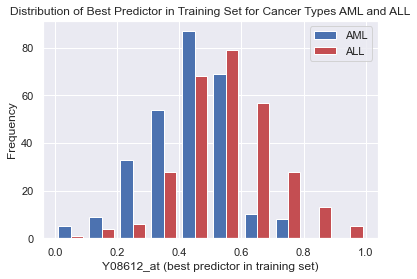

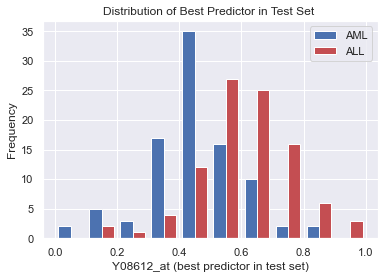

In [12]:
# create the necessary dataframes
X_train['Cancer_type'] = y_train
X_test['Cancer_type'] = y_test

AML_X_train = X_train[X_train['Cancer_type'] == 1]
ALL_X_train = X_train[X_train['Cancer_type'] == 0]

X_train = X_train.drop(columns=['Cancer_type'])
AML_X_train = AML_X_train.drop(columns=['Cancer_type'])
ALL_X_train = ALL_X_train.drop(columns=['Cancer_type'])

AML_X_test = X_test[X_test['Cancer_type'] == 1]
ALL_X_test = X_test[X_test['Cancer_type'] == 0]

X_test = X_test.drop(columns=['Cancer_type'])
AML_X_test = AML_X_test.drop(columns=['Cancer_type'])
ALL_X_test = ALL_X_test.drop(columns=['Cancer_type'])

plt.hist([AML_X_train[best_predictor], ALL_X_train[best_predictor]], color=['b', 'r'], label=['AML', 'ALL'])
plt.title("Distribution of Best Predictor in Training Set for Cancer Types AML and ALL")
plt.xlabel(best_predictor + " (best predictor in training set)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist([AML_X_test[best_predictor], ALL_X_test[best_predictor]], color=['b', 'r'], label=['AML', 'ALL'])
plt.title("Distribution of Best Predictor in Test Set ")
plt.xlabel(best_predictor + " (best predictor in test set)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**1.4 Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.**


In [52]:
print("The accuracy of the best predictor is {}".format(max_accuracy))

y_preds = [0.0 if y_pred >= 0.5 else 1.0 for y_pred in logistic_model_best_predictor.predict_proba(np.array(y_test).reshape(-1, 1))[:,1]]
acc = 0
for i in range(len(y_test)):
    if y_preds[i] == np.array(y_test).reshape(-1, 1)[i][0]:
        acc = acc + 1
        
acc / len(y_test)

The accuracy of the best predictor is 0.723404255319149


1.0

In [50]:
y_test

730    0.0
405    0.0
146    1.0
130    0.0
620    0.0
217    1.0
172    1.0
568    1.0
136    0.0
666    0.0
188    1.0
575    1.0
467    0.0
655    1.0
692    1.0
241    0.0
60     1.0
569    0.0
221    1.0
339    0.0
243    1.0
310    0.0
53     0.0
19     0.0
586    1.0
99     1.0
679    1.0
484    0.0
311    1.0
554    0.0
      ... 
445    0.0
317    1.0
578    0.0
750    0.0
295    0.0
151    0.0
359    0.0
634    1.0
505    0.0
203    0.0
400    1.0
674    1.0
45     0.0
32     1.0
515    0.0
112    0.0
194    1.0
175    0.0
617    0.0
170    1.0
669    1.0
682    0.0
513    0.0
511    1.0
73     1.0
161    0.0
393    0.0
417    1.0
109    0.0
525    1.0
Name: Cancer_type, Length: 188, dtype: float64

It seems like a value of around $0.5$ works to separate the two classes based on the `best_predictor`. It is especially clear on the test set (and also on the train set) that most of the AML cases are when `best_predictor` $< 0.5$ and most ALL cases are on the other side of $0.5$. 

---

<div class='exercise'> <b> Question 2 [35pts]: Logistic Regression Modeling </b> </div>


**2.1** Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type.  Carefully interpret the coefficient estimates for this model.

*Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use `C=100000` or `penalty = "none"`).

**2.2** Plot the logistic curves for the model in 2.1 ($y$-axis is probability scale, $x$-axis is `best_predictor`).  Interpret this plot: at what values of your `best_predictor` will you predict the patient to have ALL?  How does this compare to your eeballed value from 1.4?

**2.3** Calculate the training and test classification accuracies of this model in 2.1. How do these compare to the eye-balled model from 1.4?


**2.4** Next, fit a multiple logistic regression model with **all** the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?  

**2.5** Print out and interpret the logistic regression coefficients for  `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?

**2.6** Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set (choose between 20 reasonable values of $\lambda$). Report the classification accuracy on both the training and testing set.

**2.7** How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.4?


## Answers

**2.1 Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. Carefully interpret the coefficient estimates for this model.**

In [14]:
logistic_model_best_predictor = LogisticRegression(C=100000,fit_intercept=True).fit(X_train[best_predictor].values.reshape(-1, 1), y_train)
print("Logistic Regression Estimated Intercept:", logistic_model_best_predictor.intercept_[0])
print("Logistic Regression Estimated Slope:", logistic_model_best_predictor.coef_[0][0])

Logistic Regression Estimated Intercept: 2.937615016449479
Logistic Regression Estimated Slope: -6.061975252577716


** your answer here**

# Come back to this


**2.2 Plot the logistic curves for the model in 2.1 ($y$-axis is probability scale, $x$-axis is `best_predictor`).  Interpret this plot: at what values of your `best_predictor` will you predict the patient to have ALL?  How does this compare to your eeballed value from 1.4?**


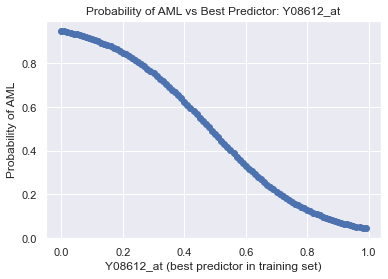

Values of best predictor that are greater than this threshold are more likely to be ALL: 0.49


In [16]:
# CHANGE X TO DUMMY LINSPACE LIST
dummy_x = np.arange(np.min(X_train[best_predictor]),np.max(X_train[best_predictor]),0.01)

plt.scatter(dummy_x, logistic_model_best_predictor.predict_proba(dummy_x.reshape(-1, 1))[:,1])
plt.title("Probability of AML vs Best Predictor: {}".format(best_predictor))
plt.xlabel(best_predictor + " (best predictor in training set)")
plt.ylabel("Probability of AML")
plt.show()

preds = logistic_model_best_predictor.predict_proba(dummy_x.reshape(-1, 1))[:,1]

crossover = 0
for i in range(1, len(preds)):
    if preds[i-1] >= 0.5 and preds[i] < 0.5:
        crossover = i
        break

print("Values of best predictor that are greater than this threshold are more likely to be ALL:", dummy_x[crossover])

# change the graph

For values of our best predictor Y08612_at that are greater than 0.49 will be predicted to be ALL. This value is very close to the eyeballed value in 1.4 (we had eyeballed it to be around 0.5)


**2.3 Calculate the training and test classification accuracies of this model in 2.1.  How do these compare to the eye-balled model from 1.4?**

In [172]:
train_accuracy = logistic_model_best_predictor.score(X_train[best_predictor].values.reshape(-1, 1), y_train)
test_accuracy = logistic_model_best_predictor.score(X_test[best_predictor].values.reshape(-1, 1), y_test)

print("Training Classification Accuracy: {}".format(train_accuracy))
print("Test Classification Accuracy: {}".format(test_accuracy))

Training Classification Accuracy: 0.6648936170212766
Test Classification Accuracy: 0.723404255319149


*your answer here* 


**2.4 Next, fit a multiple logistic regression model with *all* the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?**


In [53]:
multiple_logistic_model = LogisticRegression(penalty="none",fit_intercept=True).fit(X_train, y_train)
train_accuracy_multiple = multiple_logistic_model.score(X_train, y_train)
test_accuracy_multiple = multiple_logistic_model.score(X_test, y_test)

print("Training Classification Accuracy: {}".format(train_accuracy_multiple))
print("Test Classification Accuracy: {}".format(test_accuracy_multiple))

Training Classification Accuracy: 1.0
Test Classification Accuracy: 0.776595744680851


*your answer here*

**2.5 Print out and interpret the logistic regression coefficients for `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?**

In [174]:
print("Simple Logistic Regression Estimated Intercept:", logistic_model_best_predictor.intercept_[0])
print("Simple Logistic Regression Estimated Slope:", logistic_model_best_predictor.coef_[0][0])

best_predictor_index = X_train.columns.get_loc(best_predictor)

print("Multiple Logistic Regression Estimated Intercept for Best Predictor:", multiple_logistic_model.intercept_[0])
print("Multiple Logistic Regression Estimated Slope for Best Predictor:", multiple_logistic_model.coef_[0][best_predictor_index])

Simple Logistic Regression Estimated Intercept: 2.937615016449479
Simple Logistic Regression Estimated Slope: -6.061975252577716
Multiple Logistic Regression Estimated Intercept for Best Predictor: -0.04482453569359617
Multiple Logistic Regression Estimated Slope for Best Predictor: -1.00511537343333


Slope is same sign, both positive. 

**2.6 Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set (choose between 20 reasonable values of $\lambda$). Report the classification accuracy on both the training and testing set.**

In [175]:
cs_vals = range(1, 21)
best_accuracy = -1
best_model = None
for c in cs_vals:
    lasso_multiple_logistic_model = LogisticRegressionCV(Cs=c, solver='liblinear', penalty='l1', cv=5)
    lasso_multiple_logistic_model.fit(X_train, y_train)
    cur_accuracy = lasso_multiple_logistic_model.score(X_test, y_test)
    if cur_accuracy > best_accuracy:
        best_accuracy = cur_accuracy
        best_model = lasso_multiple_logistic_model
        best_c = c
        
lasso_train_accuracy = best_model.score(X_train, y_train)
lasso_test_accuracy = best_model.score(X_test, y_test)
        
print("Training Classification Accuracy with lambda {}: {}".format(best_c, lasso_train_accuracy))
print("Test Classification Accuracy with lambda {}: {}".format(best_c, lasso_test_accuracy))

Training Classification Accuracy with lambda 6: 0.900709219858156
Test Classification Accuracy with lambda 6: 0.851063829787234


**2.7 How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.4?**


In [176]:
lasso_coefficients = best_model.coef_[0]
counter = 0
for i in range(len(lasso_coefficients)):
    if lasso_coefficients[i] != 0:
        counter += 1
        
full_coefficients = multiple_logistic_model.coef_[0]
counter_full = 0
for i in range(len(full_coefficients)):
    if full_coefficients[i] != 0:
        counter_full += 1
        
print("Actual number of predictors:", X_train.shape[1])
print("LASSO-Like Regularized Multiple Logistic Regression Number of Non-zero Estimated Slopes (number of important features):", counter)
print("Full Multiple Logistic Regression Number of Non-zero Estimated Slopes (number of important features):", counter_full)



Actual number of predictors: 7129
LASSO-Like Regularized Multiple Logistic Regression Number of Non-zero Estimated Slopes (number of important features): 43
Full Multiple Logistic Regression Number of Non-zero Estimated Slopes (number of important features): 7129


There are only 42 predictors that have a non-zero coefficient for our LASSO-like regularized model meaning that our regularized model only considers 42 predictors to be important features. The full logistic regression model in 2.4 uses all 7129 predictors in comparison, so this is a very large difference.

---

<div class='exercise'> <b> Question 3 [10pts]: $k$-NN Classification </b> </div>

**3.1** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`. 

**3.2** Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.4, (ii) the best regularized model from 2.6, and (iii) the best $k$-NN from the previous part. Report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


### Answers

**3.1 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [177]:
ks = [1,3,5,7,10,15,20,50,100]
best_score = 0
best_k = 0
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    average_score = scores.mean()
    if average_score > best_score:
        best_score = average_score
        best_k = k
        
print("The best k is:", best_k)
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train,y_train)
print("Classification accuracy for knn: \n")
print("Training misclassification rate =", 1-best_knn.score(X_train, y_train),", Test misclassification rate =", 1-best_knn.score(X_test,y_test))

The best k is: 3
Classification accuracy for knn: 

Training misclassification rate = 0.08333333333333337 , Test misclassification rate = 0.18085106382978722


**3.2 Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.4, (ii) the best regularized model from 2.6, and (iii) the best $k$-NN from the previous part. what are the  false positive and false negative rates in these 3 models (all in the test set)?  Briefly interpret what you notice.**

In [178]:
from sklearn.metrics import confusion_matrix

conf_mat_multiple_logistic_model = pd.DataFrame(
    confusion_matrix(y_test, multiple_logistic_model.predict(X_test)), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

conf_mat_best_model = pd.DataFrame(
    confusion_matrix(y_test, best_model.predict(X_test)), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

conf_mat_best_knn = pd.DataFrame(
    confusion_matrix(y_test, best_knn.predict(X_test)), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

print("Confusion matrix for multiple logistic regression model: \n \n", conf_mat_multiple_logistic_model, "\n")
print("Confusion matrix for best regularized logistic regression model: \n \n", conf_mat_best_model, "\n")
print("Confusion matrix for best k-NN model: \n", conf_mat_best_knn)

Confusion matrix for multiple logistic regression model: 
 
         pred:0  pred:1
true:0      83      13
true:1      29      63 

Confusion matrix for best regularized logistic regression model: 
 
         pred:0  pred:1
true:0      85      11
true:1      17      75 

Confusion matrix for best k-NN model: 
         pred:0  pred:1
true:0      83      13
true:1      21      71


The best regularized logistic regression model performed the best on the test set compared to the other two models, since it has the highest number of true positive and negative predictions. The multiple logistic regression model and the 3-NN model have the same number of true negative predictions (83) but the 3-NN model has more true positive predictions (71 compared to 63), meaning the 3-NN model did a bit better than the multiple logistic model on the test set.

---

#### <div class='exercise'><b> Question 4 [15 pts]: Performing Principal Components Analysis </b></div>

**4.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

*Hint: be sure to standardize before performing PCA.

**4.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different colors and markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**4.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony. 



### Answers

**4.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [179]:
from sklearn.preprocessing import StandardScaler

scale_transformer = StandardScaler(copy=True).fit(X_train)
X_train_scaled = scale_transformer.transform(X_train)
X_test_scaled = scale_transformer.transform(X_test)

pca_transformer = PCA().fit(X_train_scaled)
x_train_pca = pca_transformer.transform(X_train_scaled)
x_test_pca =  pca_transformer.transform(X_test_scaled)

The limiting factor for the maximum number of PCA components for this dataset is the number of observations. This is because the number of observations in this dataset (for both X_train and X_test) are less than the number of features/predictors.


**4.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

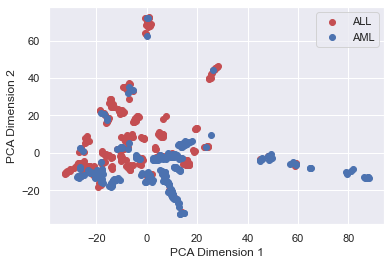

In [180]:
colors = ['r', 'b']
labels = ["ALL", "AML"]

for cur_quality in [0,1]:
    cur_df = x_train_pca[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=labels[cur_quality])

# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend();

If plot each datapoint with a color that indicates its associated label/class in the scatterplot of the two PCA dimensions, we can see how separable the transformed data is. If there is minimal overlap between the datapoints of different colors, then that means it is easier for our model to learn a relationship between the transformed input data and the response variable/label. We can visually see the amount of overlap/separation between datapoints with the scatterplot of the top 2 PCA vectors, which is especially useful since the top 2 PCA vectors are the ones that capture the most amount of variance from the original dataset.

**4.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony.**

Variance explained by each of the top 2 PCA components: [0.06456346 0.04926115]
Total Variance Explained by the top 2 PCA components: 0.11382461095205532
224 PCA vectors are needed so that 90% of the variability in the predictors is explained.


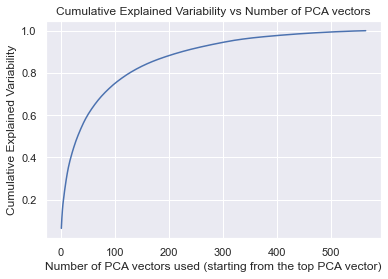

In [181]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each of the top 2 PCA components:", var_explained[0:2])
print("Total Variance Explained by the top 2 PCA components:", np.sum(var_explained[0:2]))

cumulative_variance = [var_explained[0]]
threshold_num = 0

if cumulative_variance[0] >= 0.9:
    threshold_num = 1
else:
    for i in range(1, len(var_explained)):
        cumulative_variance.append(cumulative_variance[i-1] + var_explained[i])
        if cumulative_variance[i-1] < 0.9 and cumulative_variance[i] >= 0.9:
            threshold_num = i+1
            
print("{} PCA vectors are needed so that 90% of the variability in the predictors is explained.".format(threshold_num))

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)
plt.title('Cumulative Explained Variability vs Number of PCA vectors')
plt.xlabel('Number of PCA vectors used (starting from the top PCA vector)')
plt.ylabel('Cumulative Explained Variability')
plt.show()

We see that the cumulative explained variability noticeably plateaus after the top 100 PCA vectors, so there is diminishing returns in selecting more than 100 for the number of components used. The top 100 PCA components is enough to represent the orignal dataset but also balances parsimony with the diminishing returns/plateau observation above.

---

<div class='exercise'><b> Question 5 [10 pts]: Principal Components Regression (PCR) </b></div>

**5.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?

**5.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `best_predictor` and `Cancer_type`.



### Answers

**5.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?**

In [194]:
x_train_pca_df = pd.DataFrame(x_train_pca)
x_test_pca_df =  pd.DataFrame(x_test_pca)

logistic_pca_top_2 = LogisticRegression(C=100000, solver='liblinear', max_iter=1000)
logistic_pca_top_2.fit(x_train_pca_df.iloc[:, 0:2], y_train)

logistic_pca_goldilocks = LogisticRegression(C=100000, solver='liblinear', max_iter=1000)
logistic_pca_goldilocks.fit(x_train_pca_df.iloc[:, 0:100], y_train)

logistic_pca_at_least_90 = LogisticRegression(C=100000, solver='liblinear', max_iter=1000)
logistic_pca_at_least_90.fit(x_train_pca_df.iloc[:, 0:224], y_train)

y_hat_test_top_2 = logistic_pca_top_2.predict(x_test_pca_df.iloc[:, 0:2])
top_2_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test_top_2)
print("Accuracy of logistic regression with top 2 PCA vectors: ", top_2_accuracy)

y_hat_test_goldilocks = logistic_pca_goldilocks.predict(x_test_pca_df.iloc[:, 0:100])
goldilocks_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test_goldilocks)
print("Accuracy of logistic regression with top 100 PCA vectors: ", goldilocks_accuracy)

y_hat_test_at_least_90 = logistic_pca_at_least_90.predict(x_test_pca_df.iloc[:, 0:224])
at_least_90_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test_at_least_90)
print("Accuracy of logistic regression with top 224 PCA vectors (explain at least 90% variability): ", at_least_90_accuracy)



Accuracy of logistic regression with top 2 PCA vectors:  0.7712765957446809
Accuracy of logistic regression with top 100 PCA vectors:  0.8138297872340425
Accuracy of logistic regression with top 224 PCA vectors (explain at least 90% variability):  0.7340425531914894


*your answer here*


**5.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between your `best_predictor` and `Cancer_type`**.

Average cross validation classification accuracy for Top 2 PCA Model: 0.7570164348925411
Average cross validation classification accuracy for Top 100 PCA Model: 0.8334228824273072
Average cross validation classification accuracy for Top 224 PCA Model: 0.7606352718078382


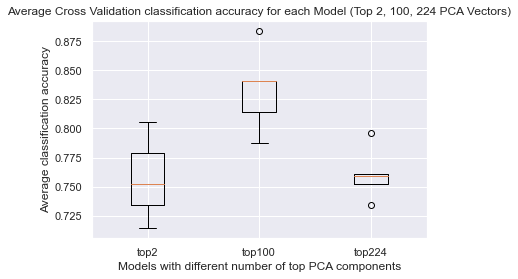

In [183]:
import warnings
warnings.filterwarnings('ignore')

np.random.RandomState(109)

n_folds = 5
k_fold = KFold(n_folds, random_state=109, shuffle=True)

X_top_2_df = x_train_pca_df.iloc[:, 0:2]
X_goldilocks_df = x_train_pca_df.iloc[:, 0:100]
X_at_least_90_df = x_train_pca_df.iloc[:, 0:224]

acc_cv_top_2 = []
acc_cv_goldilocks = []
acc_cv_at_least_90 = []

y_train_reset = y_train.reset_index(drop=True)

for traincv_index, testcv_index in k_fold.split(x_train_pca_df):
    y_traincv, y_testcv = y_train_reset[traincv_index], y_train_reset[testcv_index]
        
    X_top_2_traincv, X_top_2_testcv = X_top_2_df.loc[traincv_index], X_top_2_df.loc[testcv_index]
    X_goldilocks_traincv, X_goldilocks_testcv = X_goldilocks_df.loc[traincv_index], X_goldilocks_df.loc[testcv_index]
    X_at_least_90_traincv, X_at_least_90_testcv = X_at_least_90_df.loc[traincv_index], X_at_least_90_df.loc[testcv_index]

    model1 = LogisticRegression(fit_intercept=True).fit(X_top_2_traincv, y_traincv)
    model2 = LogisticRegression(fit_intercept=True).fit(X_goldilocks_traincv, y_traincv)
    model3 = LogisticRegression(fit_intercept=True).fit(X_at_least_90_traincv, y_traincv)

    #r2_cv_top_2.append(sk.metrics.r2_score(y_testcv, model1.predict(X_top_2_testcv)))
    #r2_cv_goldilocks.append(sk.metrics.r2_score(y_testcv, model2.predict(X_goldilocks_testcv)))
    #r2_cv_at_least_90.append(sk.metrics.r2_score(y_testcv, model3.predict(X_at_least_90_testcv)))
    
    acc_cv_top_2.append(model1.score(X_top_2_testcv, y_testcv))
    acc_cv_goldilocks.append(model2.score(X_goldilocks_testcv, y_testcv))
    acc_cv_at_least_90.append(model3.score(X_at_least_90_testcv, y_testcv))
    
print("Average cross validation classification accuracy for Top 2 PCA Model:", np.mean(acc_cv_top_2))
print("Average cross validation classification accuracy for Top 100 PCA Model:", np.mean(acc_cv_goldilocks))
print("Average cross validation classification accuracy for Top 224 PCA Model:", np.mean(acc_cv_at_least_90))

plt.boxplot([acc_cv_top_2, acc_cv_goldilocks, acc_cv_at_least_90], labels=['top2', 'top100', 'top224'])
plt.title('Average Cross Validation classification accuracy for each Model (Top 2, 100, 224 PCA Vectors)')
plt.xlabel('Models with different number of top PCA components')
plt.ylabel('Average classification accuracy')
plt.show()

From the three possible number of PCA components (2, 100 and 224), we have found the 100 PCA components results in the highest classification accuracy from cross validation. The code below transforms back to coefficients of our original predictors to find the coefficient for the best predictor in the original data set. We see that the coefficient is -0.02732666989997281.

In [216]:
pca_coefficients = model2.coef_[0].tolist()
components = pd.DataFrame(pca_transformer.components_[0:100, :], columns=list(X_train.columns))
best_predictor_weights = components[best_predictor].tolist()

best_predictor_coef = sum([a*b for a,b in zip(pca_coefficients, best_predictor_weights)])
print(best_predictor_coef)

-0.02732666989997281


<div class='exercise'><b> Question 6 [15 pts]: Evaluating Classifiers </b></div>

**6.1**: Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**6.2** Evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models using AUC.  That is calculate AUC for the following models:
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)

For the model with the best AUC, plot the ROC. Briefly interpret your plot.

**6.3** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

*See extra information about ALL and AML at the bottom of this notebook.*

### Answers

**6.1 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*


**6.2 use AUC to evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models.  That is calculate AUC for the following models:**
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)

**For the model with the best AUC, plot the ROC. Briefly interpret your plot.**



In [ ]:
######
# your code here
######


*your answer here*

**6.3 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*


<hr style="height:2pt">


**Additional Information**

Acute Lymphoblastic Leukemia (ALL):
- About 98% of children with ALL go into remission within weeks after starting treatment.
- About 90% of those children can be cured. Patients are considered cured after 10 years in remission.

Acute Myeloid Leukemia (AML):
- In general, children with AML are seen as lower risk than adults. 
- Around 85 to 90 percent of children with AML will go into remission after induction, according to the American Cancer Society. AML will return in some cases.  
- The five-year-survival-rate for children with AML is 60 to 70 percent.

<hr style="height:2pt">